In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [1]:
!mamba install -y -c rapidsai -c conda-forge -c nvidia \
    cuml=23.12 python=3.10 cudatoolkit=11.8


Looking for: ['cuml=23.12', 'python=3.10', 'cudatoolkit=11.8']

[+] 0.0s
rapidsai/linux-64 ..  ⣾  rapidsai/linux-64 (check zst)                     
[+] 0.0s
rapidsai/noarch (check zst)                        Checked  0.0s
[+] 0.0s
nvidia/linux-64 (c..  ⣾  nvidia/linux-64 (check zst)                       
[+] 0.0s
nvidia/noarch (che..  ⣾  nvidia/noarch (check zst)                         
[+] 0.0s
rapidsai/linux-64  ⣾  rapidsai/linux-64                                 
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  
rapidsai/noarch       ⣾  
nvidia/linux-64       ⣾  
nvidia/noarch         ⣾  nvidia/noarch                                     
rapidsai/noarch                                   
nvidia/linux-64                                   
[+] 0.2s
conda-forge/linux-64   5%
conda-forge/noarch     8%[+] 0.3s
conda-forge/linux-64  16%
conda-forge/noarch    30%[+] 0.4s
conda-forge/linux-64  23%
conda-forge/noarch    45%[+] 0.5s
conda-forge/linux-64  29%
conda-forge/noarch

In [2]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from cuml.svm import SVC
import cupy as cp
from cuml.svm import LinearSVC
import gc
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Χ_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_Test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Χ_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_Test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [4]:
# Reshaping των labels

y_train_reshaped = y_train.reshape(-1)
y_test_reshaped  = y_test.reshape(-1)

print("y_Train shape:", y_train_reshaped.shape)
print("Train:", y_test_reshaped.shape)

y_Train shape: (50000,)
Train: (10000,)


In [5]:
x_tr_img, x_val_img, y_tr_img, y_val_img = train_test_split(x_train, y_train_reshaped, test_size=0.2, random_state=42, stratify=y_train_reshaped)
x_tr_img_norm  = x_tr_img.astype(np.float32) / 255.0
x_val_img_norm = x_val_img.astype(np.float32) / 255.0
x_test_img_norm = x_test.astype(np.float32) / 255.0

print("X_train for CNN shape:", x_tr_img_norm.shape)

X_train for CNN shape: (40000, 32, 32, 3)


In [6]:
cnn = load_model("final_model6.h5")

In [7]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,118,764 (4.27 MB)

 Trainable params: 1,117,866 (4.26 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)

In [20]:
# CNN feature extraction
# Με την tf.keras.Model, παιρνω τις εξοδους του activation_4 layer, πριν το τελευταιο dense 10 νευρονων με τη softmax
# Ετσι εχω παρει 256 features ανα εικονα τα οποια ειναι πολυ καλυτερα απο τις raw pixel values που εδινα στο SVM στην αρχη,
# διοτι εχουν περασει/επεξεργαστει απο ολοκληρο CNN

feature_model = tf.keras.Model(inputs=cnn.inputs, outputs=cnn.get_layer("activation_4").output)

In [28]:
# Forward pass στο CNN ωστε να παρω τις εξοδους, σε batches των 256

Features_tr = feature_model.predict(x_tr_img_norm, batch_size=256)
Features_val = feature_model.predict(x_val_img_norm, batch_size=256)

print(Features_tr.shape, Features_val.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(40000, 256) (10000, 256)


In [32]:
# Scaling z=(x-μ)/σ των features εξοδου του CNN πριν μπουν στο SVM

scaler = StandardScaler()
F_tr_sc = scaler.fit_transform(Features_tr)
F_val_sc = scaler.transform(Features_val)

In [30]:
F_tr_gpu  = cp.asarray(F_tr_sc)
F_val_gpu = cp.asarray(F_val_sc)

y_tr_gpu  = cp.asarray(y_tr_img)
y_val_gpu = cp.asarray(y_val_img)

In [ ]:
# Εκπαιδευση SVM με τα scaled features του CNN

svm1 = SVC(kernel="rbf", C=5.0, gamma="scale")
svm1.fit(F_tr_gpu, y_tr_gpu)

SVC()

In [ ]:
# Train accuracy
train_pred = svm1.predict(F_tr_gpu)
train_acc  = accuracy_score(cp.asnumpy(y_tr_gpu), cp.asnumpy(train_pred))

# Validation accuracy
val_pred = svm1.predict(F_val_gpu)
val_acc  = accuracy_score(cp.asnumpy(y_val_gpu), cp.asnumpy(val_pred))

print("CNN + SVM train accuracy:", train_acc)
print("CNN + SVM validation accuracy:", val_acc)

CNN + SVM train accuracy: 0.99985
CNN + SVM validation accuracy: 0.927


In [ ]:
svm2 = LinearSVC(C=1.0, max_iter=3000)
svm2.fit(F_tr_gpu, y_tr_gpu)

LinearSVC()

In [ ]:
# Train accuracy
train_pred = svm2.predict(F_tr_gpu)
train_acc  = accuracy_score(cp.asnumpy(y_tr_gpu), cp.asnumpy(train_pred))

# Validation accuracy
val_pred = svm2.predict(F_val_gpu)
val_acc  = accuracy_score(cp.asnumpy(y_val_gpu), cp.asnumpy(val_pred))

print("CNN + SVM train accuracy:", train_acc)
print("CNN + SVM validation accuracy:", val_acc)

CNN + SVM train accuracy: 0.9826
CNN + SVM validation accuracy: 0.9242


In [ ]:
svm3 = SVC(kernel="poly", degree=3, C=40.0, coef0=1)
svm3.fit(F_tr_gpu, y_tr_gpu)

SVC()

In [ ]:
# Train accuracy
train_pred = svm3.predict(F_tr_gpu)
train_acc  = accuracy_score(cp.asnumpy(y_tr_gpu), cp.asnumpy(train_pred))

# Validation accuracy
val_pred = svm3.predict(F_val_gpu)
val_acc  = accuracy_score(cp.asnumpy(y_val_gpu), cp.asnumpy(val_pred))

print("CNN + SVM train accuracy:", train_acc)
print("CNN + SVM validation accuracy:", val_acc)

CNN + SVM train accuracy: 1.0
CNN + SVM validation accuracy: 0.9223


In [ ]:
svm4 = SVC(kernel="rbf", C=2.3, gamma=0.00064)
svm4.fit(F_tr_gpu, y_tr_gpu)

SVC()

In [ ]:
# Train accuracy
train_pred = svm4.predict(F_tr_gpu)
train_acc  = accuracy_score(cp.asnumpy(y_tr_gpu), cp.asnumpy(train_pred))

# Validation accuracy
val_pred = svm4.predict(F_val_gpu)
val_acc  = accuracy_score(cp.asnumpy(y_val_gpu), cp.asnumpy(val_pred))

print("CNN + SVM train accuracy:", train_acc)
print("CNN + SVM validation accuracy:", val_acc)

CNN + SVM train accuracy: 0.981275
CNN + SVM validation accuracy: 0.9262


In [ ]:
svm5 = SVC(kernel="rbf", C=1.0, gamma="scale")
svm5.fit(F_tr_gpu, y_tr_gpu)

SVC()

In [ ]:
# Train accuracy
train_pred = svm5.predict(F_tr_gpu)
train_acc  = accuracy_score(cp.asnumpy(y_tr_gpu), cp.asnumpy(train_pred))

# Validation accuracy
val_pred = svm5.predict(F_val_gpu)
val_acc  = accuracy_score(cp.asnumpy(y_val_gpu), cp.asnumpy(val_pred))

print("CNN + SVM train accuracy:", train_acc)
print("CNN + SVM validation accuracy:", val_acc)

CNN + SVM train accuracy: 0.9923
CNN + SVM validation accuracy: 0.9264


# **Evaluate best CNN+SVM model (svm4) on Test Set**

In [25]:
svm4 = SVC(kernel="rbf", C=2.3, gamma=0.00064)
start = time.time()
svm4.fit(F_tr_gpu, y_tr_gpu)
train_time = time.time() - start

# Train accuracy
train_pred = svm4.predict(F_tr_gpu)
pred_time = time.time() - start
train_acc  = accuracy_score(cp.asnumpy(y_tr_gpu), cp.asnumpy(train_pred))

# Validation accuracy
val_pred = svm4.predict(F_val_gpu)
val_acc  = accuracy_score(cp.asnumpy(y_val_gpu), cp.asnumpy(val_pred))

print("CNN + SVM train accuracy:", train_acc)
print("CNN + SVM validation accuracy:", val_acc)
print(f"\n Train time: {train_time:.2f}s")
print(f"Prediction time: {pred_time:.2f}s")

CNN + SVM train accuracy: 0.981275
CNN + SVM validation accuracy: 0.9262

 Train time: 1.68s
Prediction time: 3.67s


In [35]:
# Preprocess test set

Features_test = feature_model.predict(x_test_img_norm, batch_size=256)
F_test_sc = scaler.transform(Features_test)
F_test_gpu  = cp.asarray(F_test_sc)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [36]:
test_pred = svm4.predict(F_test_gpu)
test_time = time.time() - start
test_acc  = accuracy_score(y_test_reshaped, cp.asnumpy(test_pred))
print("CNN + SVM test accuracy:", test_acc)
print(f"Test prediction time: {test_time:.2f}s")

CNN + SVM test accuracy: 0.8755
Test prediction time: 1238.15s


# **Confusion Matrix**

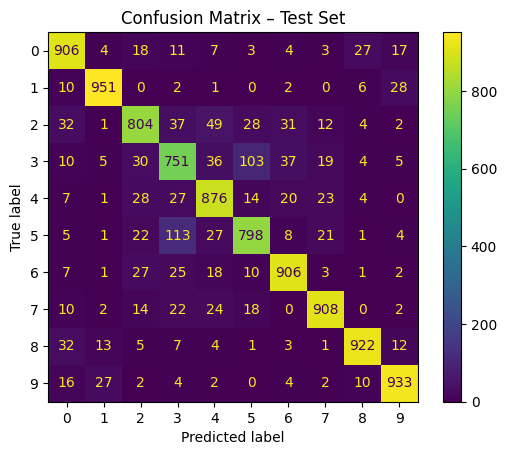

In [34]:
cm = confusion_matrix(y_test_reshaped, cp.asnumpy(test_pred))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix – Test Set")
plt.show()

# **Correct + Wrong Predictions on Test Set**

In [47]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def show_correct_and_wrong(x_img, y_true, y_pred, n, title=""):

    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    fig.suptitle(title, fontsize=14)

    correct_idx = np.where(y_pred == y_true)[0]
    wrong_idx   = np.where(y_pred != y_true)[0]

    correct = correct_idx[:n]
    wrong   = wrong_idx[:n]

    # Σωστες Προβλεψεις
    for j, idx in enumerate(correct):
        ax = axes[0, j]
        ax.imshow(x_img[idx])
        ax.set_title(f"True: {class_names[y_true[idx]]} / Pred: {class_names[y_pred[idx]]}")
        ax.axis("off")

    # Λαθος Προβλεψεις
    for j, idx in enumerate(wrong):
        ax = axes[1, j]
        ax.imshow(x_img[idx])
        ax.set_title(f"True: {class_names[y_true[idx]]} / Pred: {class_names[y_pred[idx]]}")
        ax.axis("off")

    axes[0, 0].set_ylabel("Correct", fontsize=12)
    axes[1, 0].set_ylabel("Wrong", fontsize=12)

    plt.tight_layout()
    plt.show()

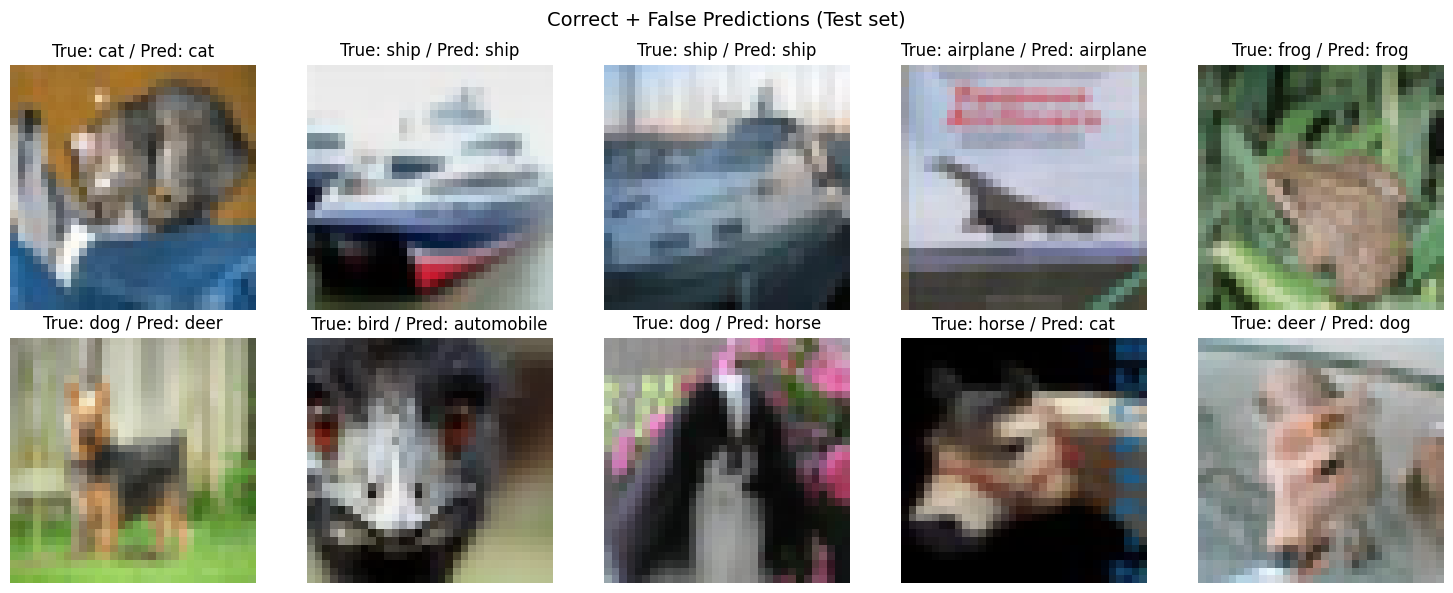

In [48]:
show_correct_and_wrong(x_test, y_test_reshaped, cp.asnumpy(test_pred), n=5, title="Correct + False Predictions (Test set)")